In [1]:
import json
import os
import pickle
from datetime import datetime
from glob import glob

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.sparse import csr_matrix, hstack
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import Lasso, Ridge, RidgeCV, SGDRegressor
from sklearn.metrics import mean_absolute_error
from tqdm.notebook import tqdm

In [2]:
from html.parser import HTMLParser


class MLStripper(HTMLParser):
    def __init__(self):
        self.reset()
        self.strict = False
        self.convert_charrefs = True
        self.fed = []

    def handle_data(self, d):
        self.fed.append(d)

    def get_data(self):
        return "".join(self.fed)


def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()

In [3]:
def read_json_line(line=None):
    result = None
    try:
        result = json.loads(line)
    except Exception as e:
        # Find the offending character index:
        idx_to_replace = int(str(e).split(" ")[-1].replace(")", ""))
        # Remove the offending character:
        new_line = list(line)
        new_line[idx_to_replace] = " "
        new_line = "".join(new_line)
        return read_json_line(line=new_line)
    return result

In [4]:
def extract_features_and_write(path_to_data, inp_filename, is_train=True):

    features = ["content", "published", "title", "author"]
    prefix = "train" if is_train else "test"
    feature_files = [
        open(
            os.path.join(path_to_data, "{}_{}.txt".format(prefix, feat)),
            "w",
            encoding="utf-8",
        )
        for feat in features
    ]

    with open(
        os.path.join(path_to_data, inp_filename), encoding="utf-8"
    ) as inp_json_file:

        for line in tqdm(inp_json_file):
            json_data = read_json_line(line)
            for i, feat in enumerate(features):
                if feat == "published":
                    info = json_data[feat]["$date"]
                elif feat == "author":
                    info = json_data[feat]["twitter"]
                    if info:
                        info = info.replace("\n", " ").replace("@", " ")
                    else:
                        info = ""
                elif feat == "content" or feat == "title":
                    info = json_data[feat].replace("\n", " ").replace("\r", " ")
                    info = strip_tags(info)
                feature_files[i].write(info + "\n")

In [5]:
PATH_TO_DATA = "../../_static/data/assignment6/"  # modify this if you need to

In [6]:
%%time
extract_features_and_write(PATH_TO_DATA, "train.json", is_train=True)

0it [00:00, ?it/s]

CPU times: user 3min 15s, sys: 3.27 s, total: 3min 18s
Wall time: 3min 19s


In [7]:
%%time
extract_features_and_write(PATH_TO_DATA, "test.json", is_train=False)

0it [00:00, ?it/s]

CPU times: user 1min 59s, sys: 2.44 s, total: 2min 2s
Wall time: 2min 3s


In [8]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=100000)

In [9]:
%%time
with open(
    os.path.join(PATH_TO_DATA, "train_content.txt"), encoding="utf-8"
) as input_train_file:
    X_train_content_sparse = tfidf_vectorizer.fit_transform(input_train_file)

with open(
    os.path.join(PATH_TO_DATA, "test_content.txt"), encoding="utf-8"
) as input_test_file:
    X_test_content_sparse = tfidf_vectorizer.transform(input_test_file)

CPU times: user 7min 16s, sys: 21.6 s, total: 7min 38s
Wall time: 7min 42s


In [10]:
X_train_content_sparse.shape, X_test_content_sparse.shape

((62313, 100000), (34645, 100000))

In [11]:
%%time
tfidf_vectorizer_title = TfidfVectorizer(ngram_range=(1, 3), max_features=100000)

with open(
    os.path.join(PATH_TO_DATA, "train_title.txt"), encoding="utf-8"
) as input_train_file:
    X_train_title_sparse = tfidf_vectorizer_title.fit_transform(input_train_file)

with open(
    os.path.join(PATH_TO_DATA, "test_title.txt"), encoding="utf-8"
) as input_test_file:
    X_test_title_sparse = tfidf_vectorizer_title.transform(input_test_file)

CPU times: user 5.48 s, sys: 141 ms, total: 5.62 s
Wall time: 5.66 s


In [12]:
X_train_title_sparse.shape, X_test_title_sparse.shape

((62313, 100000), (34645, 100000))

In [13]:
def add_time_features(path_to_publication_time_file):

    df = pd.read_csv(path_to_publication_time_file, names=["time"])
    df["time"] = df["time"].apply(
        lambda t: pd.to_datetime(t.replace("T", " ").replace("Z", ""))
    )
    df["hour"] = df["time"].apply(lambda ts: ts.hour)
    df["month"] = df["time"].apply(lambda ts: ts.month)

    df["weekend"] = (
        df["time"]
        .apply(lambda ts: ts.weekday() == 5 or ts.weekday() == 6)
        .astype("int")
    )

    df["day"] = ((df["hour"] >= 12) & (df["hour"] <= 18)).astype("int")
    df["morning"] = ((df["hour"] >= 7) & (df["hour"] <= 11)).astype("int")
    df["night"] = ((df["hour"] >= 0) & (df["hour"] <= 5)).astype("int")

    cols = ["day", "morning", "night", "month", "weekend"]
    X_time_features_sparse = csr_matrix(df[cols].values)

    return X_time_features_sparse

In [14]:
%%time
X_train_time_features_sparse = add_time_features(
    os.path.join(PATH_TO_DATA, "train_published.txt")
)
X_test_time_features_sparse = add_time_features(
    os.path.join(PATH_TO_DATA, "test_published.txt")
)

CPU times: user 15.5 s, sys: 297 ms, total: 15.8 s
Wall time: 15.9 s


In [15]:
X_train_time_features_sparse.shape, X_test_time_features_sparse.shape

((62313, 5), (34645, 5))

In [16]:
%%time
author_train = pd.read_csv(
    os.path.join(PATH_TO_DATA, "train_author.txt"),
    names=["author"],
    skip_blank_lines=False,
)
author_train = pd.get_dummies(author_train)

author_test = pd.read_csv(
    os.path.join(PATH_TO_DATA, "test_author.txt"),
    names=["author"],
    skip_blank_lines=False,
)
author_test = pd.get_dummies(author_test)

unique_authors_train = list(set(author_train.columns) - set(author_test.columns))
unique_authors_test = list(set(author_test.columns) - set(author_train.columns))

author_test = author_test.drop(unique_authors_test, axis=1)
author_train = author_train.drop(unique_authors_train, axis=1)

X_train_author_sparse = csr_matrix(author_train.values)
X_test_author_sparse = csr_matrix(author_test.values)

CPU times: user 18.2 s, sys: 2.02 s, total: 20.2 s
Wall time: 20.4 s


In [17]:
X_train_author_sparse.shape, X_test_author_sparse.shape

((62313, 4587), (34645, 4587))

In [18]:
X_train_sparse = hstack(
    [
        X_train_content_sparse,
        X_train_title_sparse,
        X_train_author_sparse,
        X_train_time_features_sparse,
    ]
).tocsr()

In [19]:
X_test_sparse = hstack(
    [
        X_test_content_sparse,
        X_test_title_sparse,
        X_test_author_sparse,
        X_test_time_features_sparse,
    ]
).tocsr()

In [20]:
X_train_sparse.shape, X_test_sparse.shape

((62313, 204592), (34645, 204592))

In [21]:
train_target = pd.read_csv(
    os.path.join(PATH_TO_DATA, "train_log1p_recommends.csv"), index_col="id"
)
y_train = train_target["log_recommends"].values

In [22]:
train_part_size = int(0.7 * train_target.shape[0])
X_train_part_sparse = X_train_sparse[:train_part_size, :]
y_train_part = y_train[:train_part_size]
X_valid_sparse = X_train_sparse[train_part_size:, :]
y_valid = y_train[train_part_size:]

In [23]:
%%time
ridge_reg = Ridge(random_state=17)
ridge_reg.fit(X_train_part_sparse, y_train_part)
ridge_valid_pred = ridge_reg.predict(X_valid_sparse)
print(mean_absolute_error(y_valid, ridge_valid_pred))

1.103242654989497
CPU times: user 1min 43s, sys: 34.9 s, total: 2min 18s
Wall time: 29.1 s


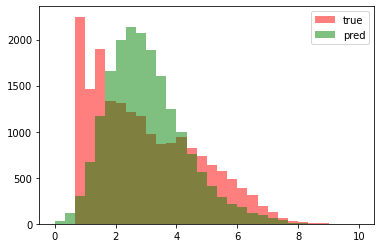

In [24]:
plt.hist(y_valid, bins=30, alpha=0.5, color="red", label="true", range=(0, 10))
plt.hist(
    ridge_valid_pred, bins=30, alpha=0.5, color="green", label="pred", range=(0, 10)
)
plt.legend();

In [25]:
%%time
ridge_reg.fit(X_train_sparse, y_train)
ridge_test_pred = ridge_reg.predict(X_test_sparse)

CPU times: user 2min 8s, sys: 50 s, total: 2min 58s
Wall time: 52.3 s


In [26]:
def write_submission_file(
    prediction,
    filename,
    path_to_sample=os.path.join(PATH_TO_DATA, "sample_submission.csv"),
):
    submission = pd.read_csv(path_to_sample, index_col="id")

    submission["log_recommends"] = prediction
    submission.to_csv(filename)

In [27]:
write_submission_file(
    ridge_test_pred, os.path.join(PATH_TO_DATA, "assignment6_medium_submission.csv")
)

In [28]:
write_submission_file(
    np.zeros_like(ridge_test_pred),
    os.path.join(PATH_TO_DATA, "medium_all_zeros_submission.csv"),
)

In [29]:
mean_test_target = 4.33328

In [30]:
y_train.mean()

3.051538598205832

In [31]:
ridge_test_pred_modif = ridge_test_pred + mean_test_target - y_train.mean()

In [32]:
write_submission_file(
    ridge_test_pred_modif,
    os.path.join(PATH_TO_DATA, "assignment6_medium_submission_with_hack.csv"),
)